### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Set visual style for plots
sns.set(style="whitegrid")

function for downcasting, and we will need for optimization

In [3]:
def downcaste_dtype(df):
    previous_memory_consumption = (df.memory_usage().sum()) / 1024**2 
    for col in df.columns:
        col_dtype = df[col].dtypes
        if col_dtype != 'object':
            xmin = df[col].min()
            xmax = df[col].max()
            if str(col_dtype)[0] == 'i': 
                if np.iinfo('int8').min < xmin and np.iinfo('int8').max > xmax:
                    df[col] = df[col].astype('int8')
                elif np.iinfo('int16').min < xmin and np.iinfo('int16').max > xmax:
                    df[col] = df[col].astype('int16')
                elif np.iinfo('int32').min < xmin and np.iinfo('int32').max > xmax:
                    df[col] = df[col].astype('int32')
                elif np.iinfo('int64').min < xmin and np.iinfo('int64').max > xmax:
                    df[col] = df[col].astype('int64')
                    
            elif str(col_dtype)[0] == 'f': 
                if np.finfo('float16').min < xmin and np.finfo('float16').max > xmax:
                    df[col] = df[col].astype('float16')
                elif np.finfo('float32').min < xmin and np.finfo('float32').max > xmax:
                    df[col] = df[col].astype('float32')
                elif np.finfo('float64').min < xmin and np.finfo('float64').max > xmax:
                    df[col] = df[col].astype('float64')
            else:
                pass

    after_memory_consumption = (df.memory_usage().sum()) / 1024**2
    percentage_of_decrease = ((previous_memory_consumption - after_memory_consumption) / previous_memory_consumption) * 100

    print('Memory usage before downcasting: {:.2f} MB'.format(previous_memory_consumption))
    print('After Downcasting the memory usage decreased to: {:.2f} MB'.format(after_memory_consumption))
    print('Memory usage decreased by {:.3f}%'.format(percentage_of_decrease))

    return df

### Loading Data

In [4]:
loan_applications = pd.read_csv('../DataSet/loan_applications_train.csv')

In [5]:
# optimizing
loan_applications = downcaste_dtype(loan_applications)

Memory usage before downcasting: 286.23 MB
After Downcasting the memory usage decreased to: 92.38 MB
Memory usage decreased by 67.725%


### Data Cleaning and Preprocessing

In [7]:
print(pd.__version__)

1.4.2


In [6]:
# Checking for missing values
missing_values = loan_applications.isnull().sum()

# handling missing values
loan_applications['amt_income_total'].fillna(loan_applications['amt_income_total'].median(), inplace=True)
loan_applications['name_contract_type'].fillna(loan_applications['name_contract_type'].mode()[0], inplace=True)

# Converting days to years for readability
loan_applications['age_years'] = loan_applications['days_birth'] / -365

C:\Users\ABDERRAHMANE\AppData\Local\Temp\ipykernel_32156\3911978451.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  loan_applications['age_years'] = loan_applications['days_birth'] / -365


### Exploratory Data Analysis (EDA)

Summary statistics

In [41]:
summary = loan_applications.describe()

Distribution of key numerical features

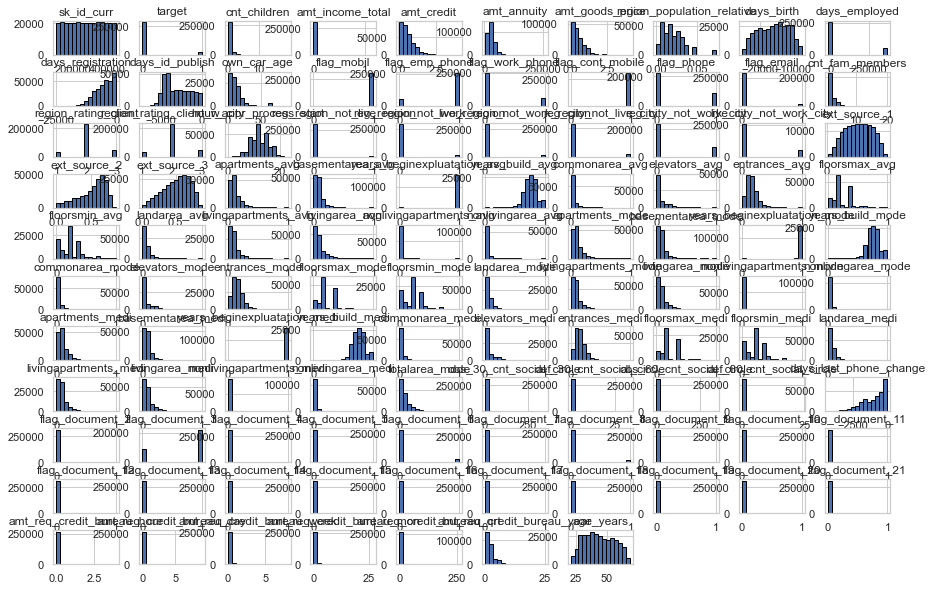

In [42]:
loan_applications.hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.subplots_adjust(hspace=0.5)

Pair Plot for selected features

Text(0.5, 0.98, 'Pairwise Plots of Key Features')

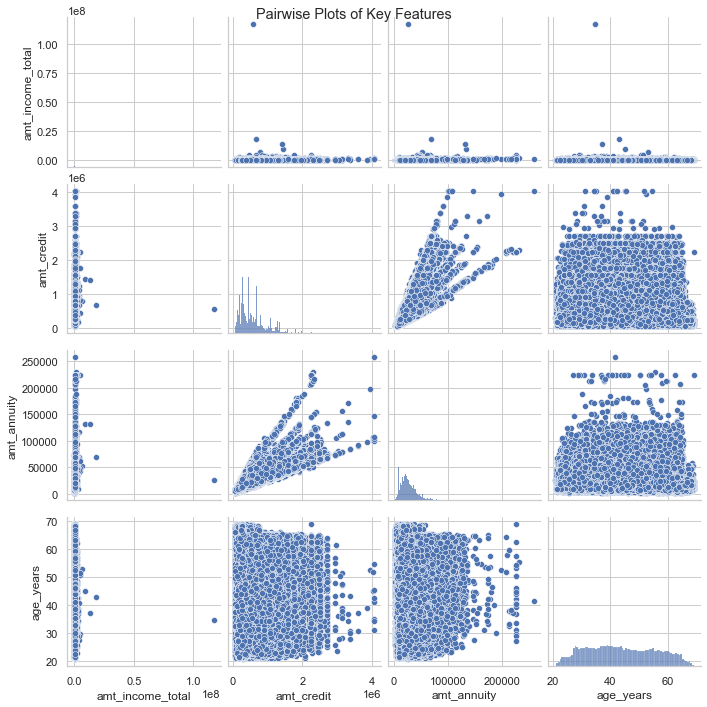

In [43]:
selected_features = ['amt_income_total', 'amt_credit', 'amt_annuity', 'age_years']
sns.pairplot(loan_applications[selected_features])
plt.suptitle('Pairwise Plots of Key Features')

Gender distribution

Text(0.5, 1.0, 'Gender Distribution')

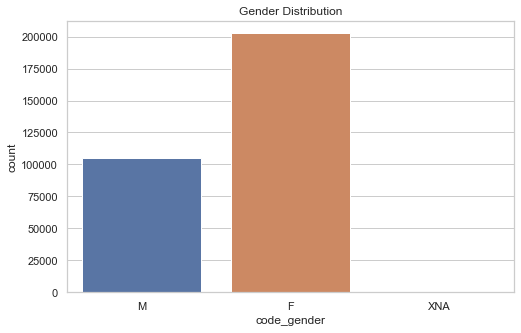

In [44]:
plt.figure(figsize=(8, 5))
sns.countplot(x='code_gender', data=loan_applications)
plt.title('Gender Distribution')

Income distribution (with log transformation for better visualization)

c:\Users\ABDERRAHMANE\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

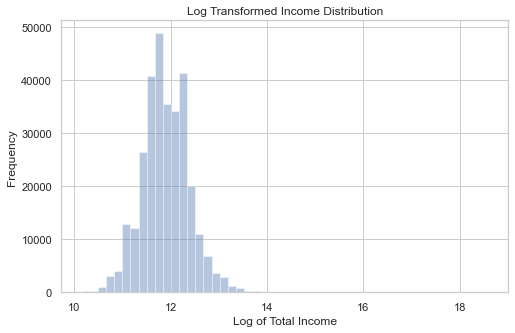

In [45]:
plt.figure(figsize=(8, 5))
sns.distplot(np.log1p(loan_applications['amt_income_total']), kde=False)
plt.title('Log Transformed Income Distribution')
plt.xlabel('Log of Total Income')
plt.ylabel('Frequency')

Boxplot for income by gender

Text(0.5, 1.0, 'Income Distribution by Gender')

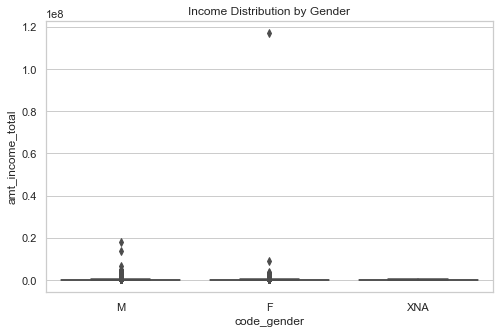

In [46]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='code_gender', y='amt_income_total', data=loan_applications)
plt.title('Income Distribution by Gender')

Correlation analysis with heatmap

Text(0.5, 1.0, 'Correlation Matrix')

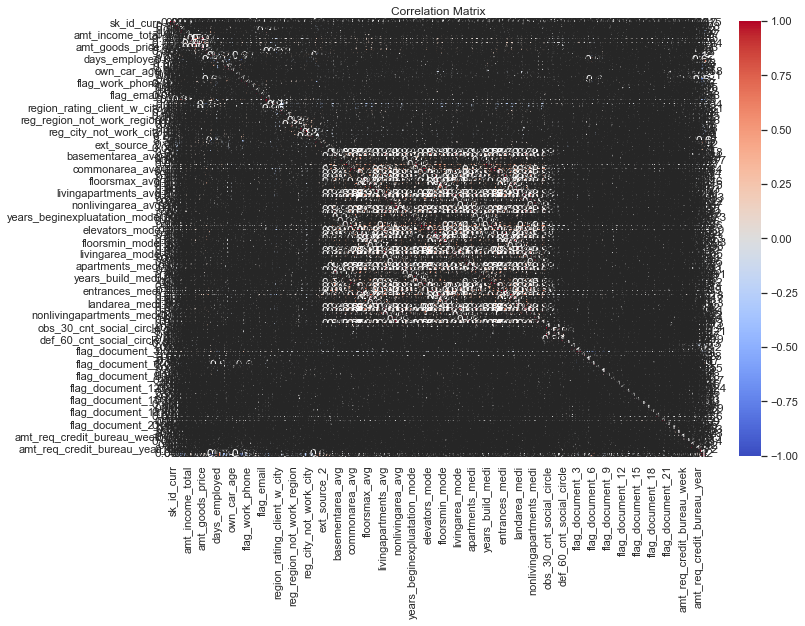

In [47]:
correlation_matrix = loan_applications.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

Income vs Loan Amount with Hue for Contract Type

Text(0, 0.5, 'Credit Amount')

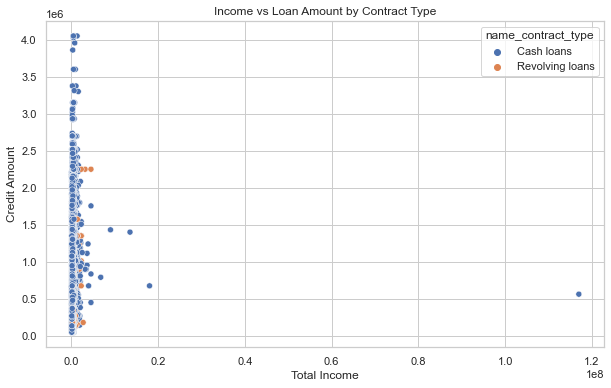

In [48]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='amt_income_total', y='amt_credit', hue='name_contract_type', data=loan_applications)
plt.title('Income vs Loan Amount by Contract Type')
plt.xlabel('Total Income')
plt.ylabel('Credit Amount')

Average income by contract type

In [49]:
avg_income_by_contract = loan_applications.groupby('name_contract_type')['amt_income_total'].mean()

KDE Plot of Age for different Contract Types

Text(0, 0.5, 'Density')

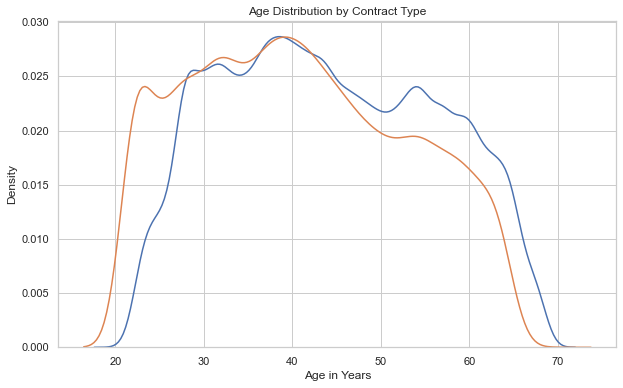

In [50]:
plt.figure(figsize=(10, 6))
for contract_type in loan_applications['name_contract_type'].unique():
    subset = loan_applications[loan_applications['name_contract_type'] == contract_type]
    sns.kdeplot(subset['age_years'], label=contract_type)
plt.title('Age Distribution by Contract Type')
plt.xlabel('Age in Years')
plt.ylabel('Density')

Z-Score for Income, for outlier detection

In [51]:
loan_applications['income_z_score'] = np.abs(stats.zscore(loan_applications['amt_income_total']))
outliers = loan_applications[loan_applications['income_z_score'] > 3]
outliers

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,age_years,income_z_score
1504,101769,0,Revolving loans,M,Y,Y,0,1080000.0,180000.0,9000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,37.350685,3.842744
1723,102015,0,Cash loans,F,N,Y,0,1935000.0,269550.0,10534.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,51.057534,7.448472
3371,103938,0,Cash loans,F,N,N,1,1350000.0,2410380.0,109053.0,...,0,0,0.0,0.0,0.0,3.0,0.0,0.0,33.460274,4.981396
4603,105384,0,Revolving loans,F,Y,Y,0,1350000.0,405000.0,20250.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,40.495890,4.981396
5673,106637,0,Cash loans,M,Y,Y,3,967500.0,450000.0,30073.5,...,0,0,0.0,0.0,0.0,1.0,1.0,0.0,32.605479,3.368307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304477,452764,0,Cash loans,F,Y,Y,1,2025000.0,935640.0,93487.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,42.553425,7.828022
305577,454039,0,Cash loans,M,Y,Y,0,1215000.0,1264738.5,67513.5,...,0,0,0.0,0.0,0.0,0.0,2.0,3.0,57.495890,4.412070
306028,454569,0,Revolving loans,M,Y,Y,0,1350000.0,1575000.0,78750.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,35.471233,4.981396
306179,454746,0,Cash loans,M,Y,Y,1,949500.0,735579.0,35518.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,38.660274,3.292397
